In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14



In [2]:
import numpy as np
import pandas as pd
import os
import glob

In [3]:
import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.INFO)

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [5]:
from pymono.config import mono_dark_6x6, mono_light_3x3, mono_light_6x6, mono_light_all_6x6

In [6]:
from pymono.aux_func import select_image_files, select_image_and_metadata, energy
from pymono.aux_func import mean_rms, weighted_mean_and_sigma

In [7]:
from pymono.plt_funcs import plot_true_positions, plot_images, plot_energies

In [8]:
from pymono.cnn_func import MonoDataset, split_data, CNN_basic, train_cnn

In [9]:
from pymono.cnn_func import test_loggin

In [10]:
test_loggin()

# Pymono

- Studies the use of a ConNN to reconstruct the positions (x,y,z) of impinging gammas in a monolithic crystal

## Setup

### dark 6 x 6

In [11]:
imgs6, mdata6 = select_image_and_metadata(mono_dark_6x6, 9)

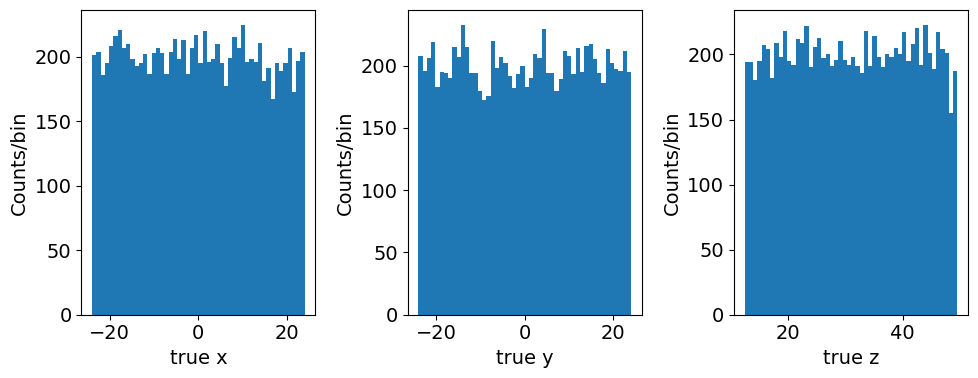

In [12]:
plot_true_positions(mdata6)

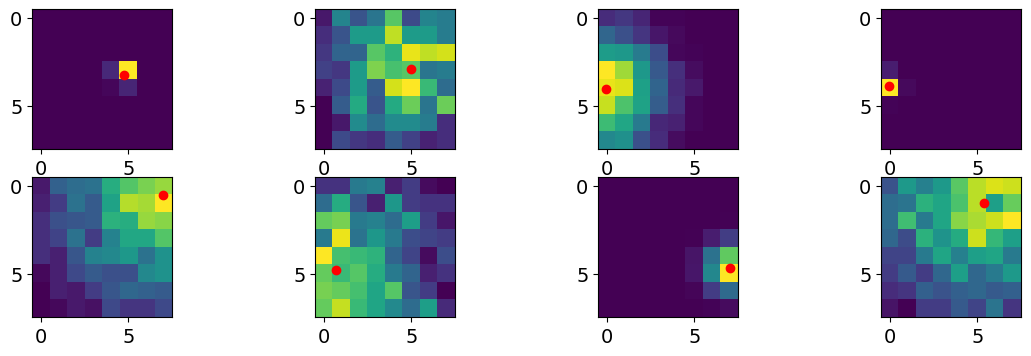

In [13]:
plot_images(imgs6, mdata6, range(0,8))

### Light 6 x 6

In [14]:
imgsl6, mdatal6 = select_image_and_metadata(mono_light_6x6, 9)

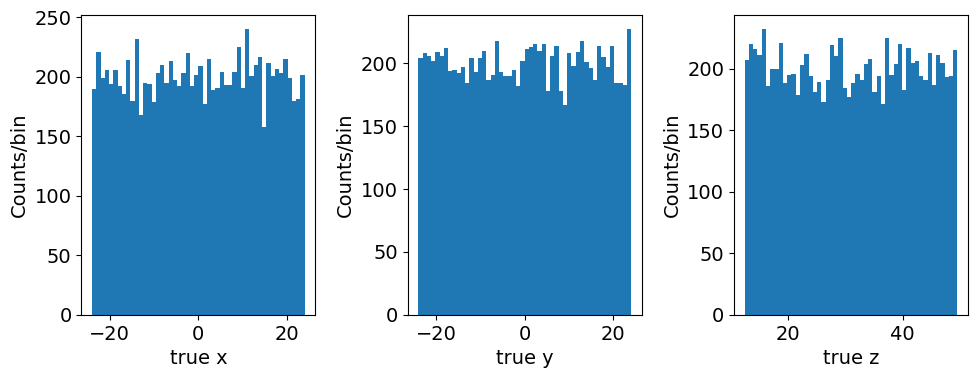

In [15]:
plot_true_positions(mdatal6)

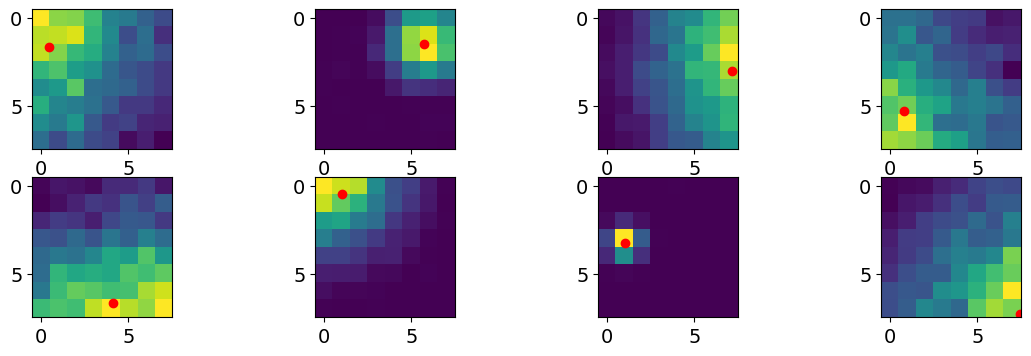

In [16]:
plot_images(imgsl6, mdatal6, range(0,8))

### Light 3 x 3

In [17]:
imgsl3, mdatal3 = select_image_and_metadata(mono_light_3x3, 9)

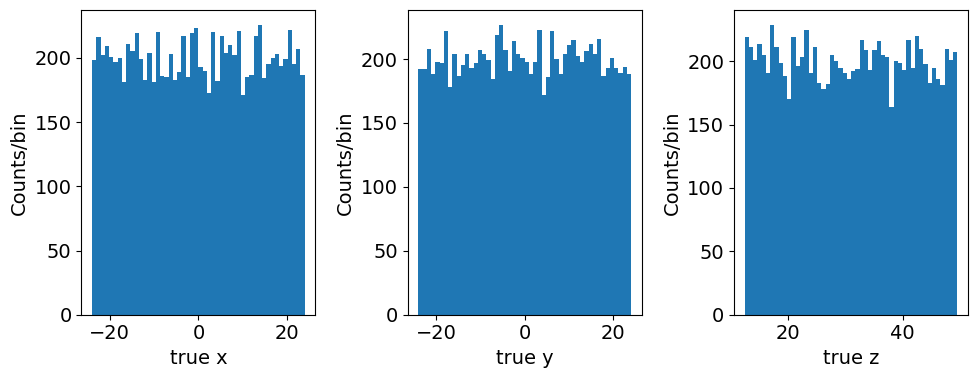

In [18]:
plot_true_positions(mdatal3)

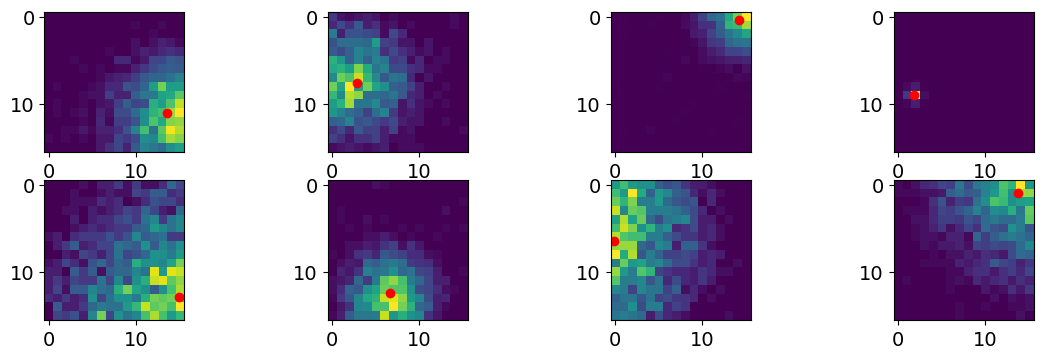

In [19]:
plot_images(imgsl3, mdatal3, range(0,8), pixel_size = 3, grid_size=16)

### Light All 6x6

In [20]:
imgsla6, mdatala6 = select_image_and_metadata(mono_light_all_6x6, 9)

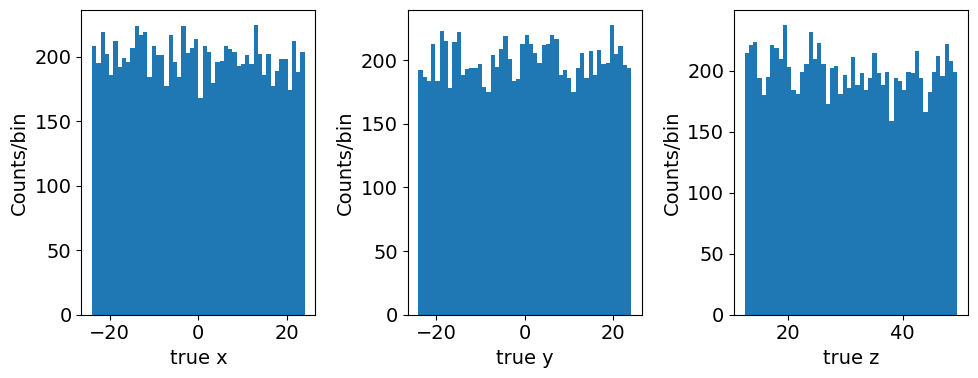

In [21]:
plot_true_positions(mdatala6)

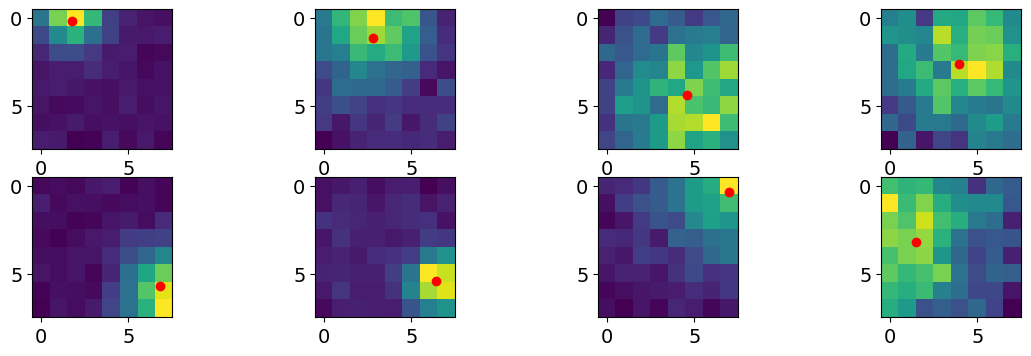

In [22]:
plot_images(imgsla6, mdatala6, range(0,8))

In [23]:
ene_light6x6 = energy(mono_light_6x6, 9)
ene_light_all_6x6 = energy(mono_light_all_6x6, 9)
ene_light3x3 = energy(mono_light_3x3, 9)
ene_dark6x6 = energy(mono_dark_6x6, 9)

In [24]:
mean6x6, std6x6, fwhm6x6 = mean_rms(ene_light6x6)
mean6x6a, std6x6a, fwhm6x6a = mean_rms(ene_light_all_6x6)
mean3x3, std3x3, fwhm3x3 = mean_rms(ene_light3x3)
mean6x6d, std6x6d, fwhm6x6d = mean_rms(ene_dark6x6)

print(f"resolution (FWHM): light 6x6     = {fwhm6x6:.2f}, light 3x3 = {fwhm3x3:.2f} ")
print(f"resolution (FWHM): light 6x6 all = {fwhm6x6a:.2f}, dark = {fwhm6x6d:.2f} ")

resolution (FWHM): light 6x6     = 0.05, light 3x3 = 0.06 
resolution (FWHM): light 6x6 all = 0.03, dark = 0.84 


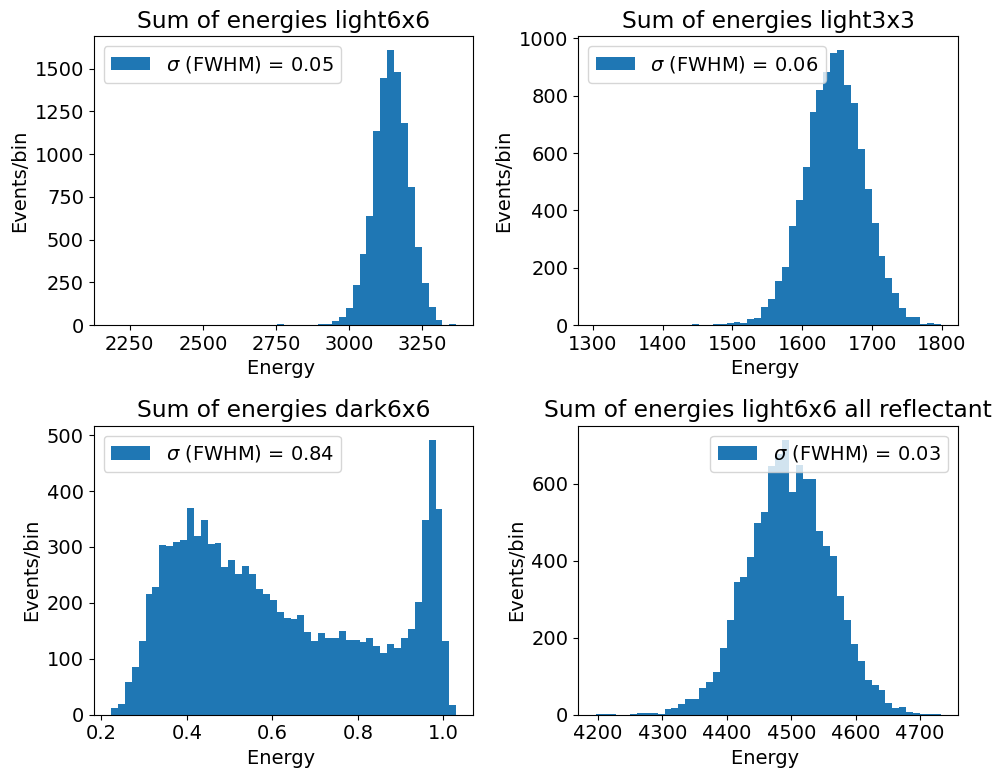

In [25]:
plot_energies(ene_light6x6, ene_light_all_6x6, ene_light3x3, ene_dark6x6)

In [26]:
first_file = 0  # initial file
last_file  = 30  # lasta file
batch_size = 1000  # Batch size
dataset = MonoDataset(mono_dark_6x6, first_file, last_file)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
ntot_evts = len(dataset)
print(f"Loaded {len(dataset)} events")
# Split the data into training, validation, and test sets
trsz = split_data(dataset, train_fraction=0.7, val_fraction=0.2)
print(f" train size = {trsz.train_size}")
print(f" val size = {trsz.val_size}")
print(f" test size = {trsz.test_size}")
print(f" train indices = {trsz.train_indices}")
print(f" val indices = {trsz.val_indices}")
print(f" test indices = {trsz.test_indices}")

Loaded 300000 events
 train size = 210000
 val size = 60000
 test size = 30000
 train indices = range(0, 210000)
 val indices = range(210000, 270000)
 test indices = range(270000, 300000)


## Data set

In [27]:
# Define subsets of the dataset
train_dataset = torch.utils.data.Subset(dataset, trsz.train_indices)
print(f"{len(train_dataset)} training events ({100*len(train_dataset)/ntot_evts}%)")
val_dataset = torch.utils.data.Subset(dataset, trsz.val_indices)
print(f"{len(val_dataset)} validation events ({100*len(val_dataset)/ntot_evts}%)")
test_dataset = torch.utils.data.Subset(dataset, trsz.test_indices)
print(f"{len(test_dataset)} test events ({100*len(test_dataset)/ntot_evts}%)")

# Define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

210000 training events (70.0%)
60000 validation events (20.0%)
30000 test events (10.0%)


In [28]:
for images, positions in train_loader:
    print(images.size())
    print(positions.size())
    print(images[0,0,:,:])
    break

torch.Size([1000, 1, 8, 8])
torch.Size([1000, 3])
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0023, 0.0047, 0.0000],
        [0.0000, 0.0000, 0.0023, 0.0023, 0.0352, 0.0892, 0.0892, 0.0352],
        [0.0000, 0.0000, 0.0000, 0.0188, 0.1643, 0.4413, 0.4178, 0.1714],
        [0.0000, 0.0000, 0.0000, 0.0469, 0.3897, 1.0000, 0.9836, 0.3803]])


### Train the network with CNN_basic 

In [29]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [30]:
# Load the model.
model = CNN_basic().to(device)
print(model)

CNN_basic(
  (conv1): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 512, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc0): Linear(in_features=512, out_features=3, bias=True)
  (drop1): Dropout(p=0.2, inplace=False)
)


In [31]:
# Set up the optimizer and loss function.
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()


In [32]:
epochs = 30

In [33]:

train_losses, val_losses =train_cnn(train_loader, val_loader,
                                    model, optimizer, device, criterion, epochs=epochs)

Running for epochs ->30
input data shape =>torch.Size([1000, 1, 8, 8])
(8,8,1) => (4,4,128) =>torch.Size([1000, 128, 4, 4])
(4,4,128) => (2,2,256) =>torch.Size([1000, 256, 2, 2])
(2,2,256) => (1,1,512) =>torch.Size([1000, 512, 1, 1])
(1,1,512) => (1,1,3) =>torch.Size([1000, 512])
torch.Size([1000, 3])


INFO:--- EPOCH 0 AVG TRAIN LOSS: 13.350399843851726
INFO:--- EPOCH 0 AVG VAL LOSS: 1.6507815062999724
INFO:--- EPOCH 1 AVG TRAIN LOSS: 1.3765792216573443
INFO:--- EPOCH 1 AVG VAL LOSS: 1.5450593511263528
INFO:--- EPOCH 2 AVG TRAIN LOSS: 1.2995876709620158
INFO:--- EPOCH 2 AVG VAL LOSS: 1.144853127002716
INFO:--- EPOCH 3 AVG TRAIN LOSS: 1.2065925135498956
INFO:--- EPOCH 3 AVG VAL LOSS: 1.1113123774528504
INFO:--- EPOCH 4 AVG TRAIN LOSS: 1.1802650505588168
INFO:--- EPOCH 4 AVG VAL LOSS: 1.1367300192515055
INFO:--- EPOCH 5 AVG TRAIN LOSS: 1.1509496544088635
INFO:--- EPOCH 5 AVG VAL LOSS: 1.1482837756474813
INFO:--- EPOCH 6 AVG TRAIN LOSS: 1.1278594510895865
INFO:--- EPOCH 6 AVG VAL LOSS: 1.102049214641253
INFO:--- EPOCH 7 AVG TRAIN LOSS: 1.1218227099804652
INFO:--- EPOCH 7 AVG VAL LOSS: 1.055659219622612
INFO:--- EPOCH 8 AVG TRAIN LOSS: 1.110445837747483
INFO:--- EPOCH 8 AVG VAL LOSS: 0.9975460857152939
INFO:--- EPOCH 9 AVG TRAIN LOSS: 1.0935623688357217
INFO:--- EPOCH 9 AVG VAL LOSS: 1.0

Out of loop after epoch ->29


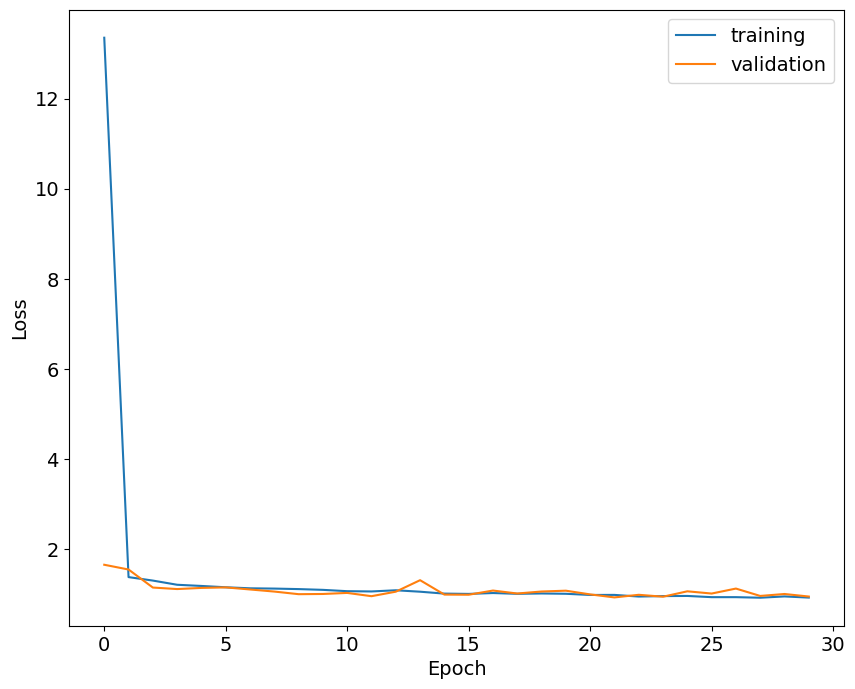

In [34]:
# Plot training and validation loss
xvals_train = np.arange(0,epochs,1)
xvals_val = np.arange(0,epochs,1)
plt.plot(xvals_train,train_losses,label='training')
plt.plot(xvals_val,val_losses,label='validation')
plt.xlabel("Epoch",fontsize=14)
plt.ylabel("Loss")
plt.legend()

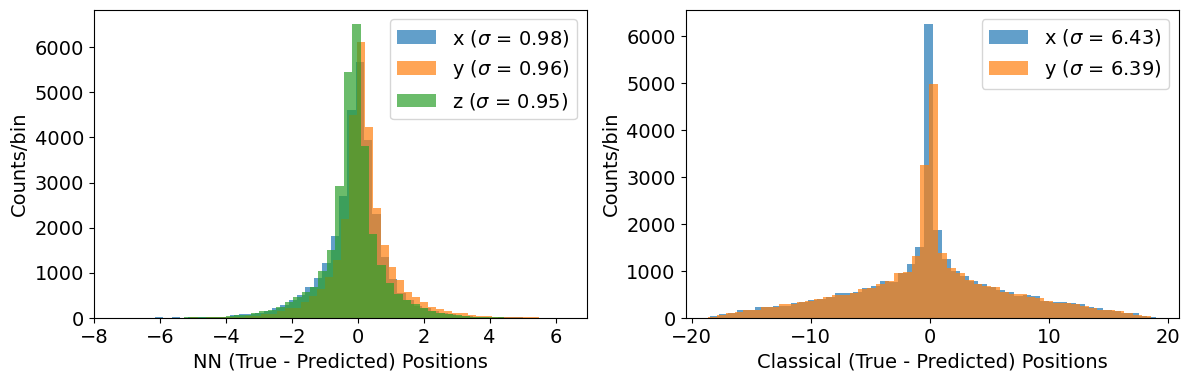

In [35]:
# Evaluate the test set.
pixel_size = 6
true_x, true_y, true_z = [],[],[]
mean_x, mean_y = [],[]
sigma_x, sigma_y = [],[]
predicted_x, predicted_y, predicted_z = [],[],[]
with torch.no_grad():

    model.eval()
    for i, (images, positions) in enumerate(test_loader):

        images = images.to(device)
        outputs = model(images).cpu()

        for x in positions[:,0]: true_x.append(x)
        for y in positions[:,1]: true_y.append(y)
        for z in positions[:,2]: true_z.append(z)

        for x in outputs[:,0]: predicted_x.append(x)
        for y in outputs[:,1]: predicted_y.append(y)
        for z in outputs[:,2]: predicted_z.append(z)

        for img in images.cpu().squeeze().numpy():
            mu_x, mu_y, sd_x, sd_y = weighted_mean_and_sigma(img)
            mean_x.append(mu_x); mean_y.append(mu_y)
            sigma_x.append(sd_x); sigma_y.append(sd_y)

# Convert to numpy arrays
true_x = np.array(true_x); true_y = np.array(true_y); true_z = np.array(true_z)
predicted_x = np.array(predicted_x); predicted_y = np.array(predicted_y); predicted_z = np.array(predicted_z)
mean_x = np.array(mean_x); mean_y = np.array(mean_y)
sigma_x = np.array(sigma_x); sigma_y = np.array(sigma_y)

# Compute deltas for the NN.
delta_x_NN = true_x - predicted_x
delta_y_NN = true_y - predicted_y
delta_z_NN = true_z - predicted_z

# Compute deltas for the classical method
delta_x_classical = true_x - pixel_size*mean_x
delta_y_classical = true_y - pixel_size*mean_y

# Histograms of (true - predicted) for x, y, and z
nbins = 50

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
flat_axes = axes.ravel()
ax0, ax1 = flat_axes[0], flat_axes[1]

ax0.hist(delta_x_NN, bins=nbins, label=f"x ($\sigma$ = {np.std(delta_x_NN):.2f})", alpha=0.7)
ax0.hist(delta_y_NN, bins=nbins, label=f"y ($\sigma$ = {np.std(delta_y_NN):.2f})", alpha=0.7)
ax0.hist(delta_z_NN, bins=nbins, label=f"z ($\sigma$ = {np.std(delta_z_NN):.2f})", alpha=0.7)
ax0.set_xlabel("NN (True - Predicted) Positions",fontsize=14)
ax0.set_ylabel("Counts/bin",fontsize=14)
ax0.legend()

ax1.hist(delta_x_classical, bins=nbins, label=f"x ($\sigma$ = {np.std(delta_x_classical):.2f})", alpha=0.7)
ax1.hist(delta_y_classical, bins=nbins, label=f"y ($\sigma$ = {np.std(delta_y_classical):.2f})", alpha=0.7)
ax1.set_xlabel("Classical (True - Predicted) Positions",fontsize=14)
ax1.set_ylabel("Counts/bin",fontsize=14)
ax1.legend()

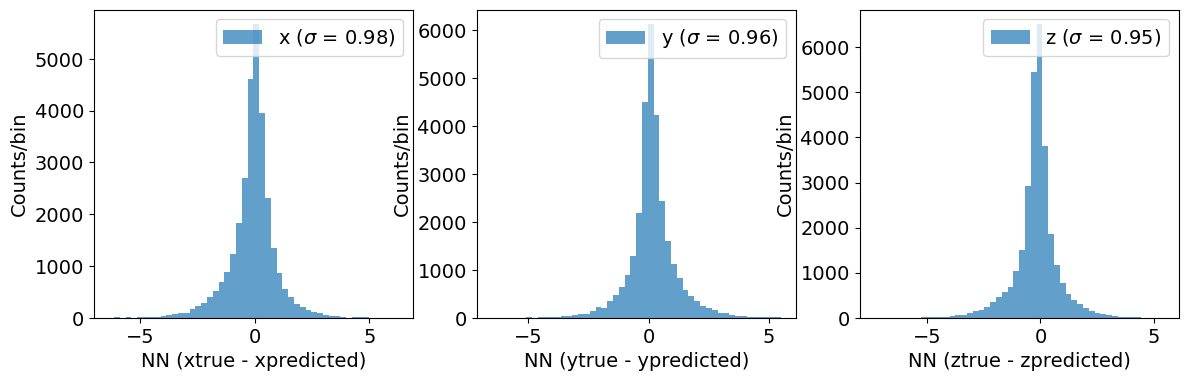

In [36]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
flat_axes = axes.ravel()
ax0, ax1, ax2 = flat_axes[0], flat_axes[1], flat_axes[2]

ax0.hist(delta_x_NN, bins=nbins, label=f"x ($\sigma$ = {np.std(delta_x_NN):.2f})", alpha=0.7)
ax0.set_xlabel("NN (xtrue - xpredicted)",fontsize=14)
ax0.set_ylabel("Counts/bin",fontsize=14)
ax0.legend()
ax1.hist(delta_y_NN, bins=nbins, label=f"y ($\sigma$ = {np.std(delta_y_NN):.2f})", alpha=0.7)
ax1.set_xlabel("NN (ytrue - ypredicted)",fontsize=14)
ax1.set_ylabel("Counts/bin",fontsize=14)
ax1.legend()
ax2.hist(delta_z_NN, bins=nbins, label=f"z ($\sigma$ = {np.std(delta_z_NN):.2f})", alpha=0.7)
ax2.set_xlabel("NN (ztrue - zpredicted)",fontsize=14)
ax2.set_ylabel("Counts/bin",fontsize=14)
ax2.legend()

In [37]:
def plotxyz(nbins=50):
    fig, axes = plt.subplots(1, 3, figsize=(14, 4))
    flat_axes = axes.ravel()
    ax0, ax1, ax2 = flat_axes[0], flat_axes[1], flat_axes[2]
    
    ax0.hist(delta_x_NN, bins=nbins, label=f"x ($\sigma$ = {np.std(delta_x_NN):.2f})", alpha=0.7)
    ax0.set_xlabel("NN (xtrue - xpredicted)",fontsize=14)
    ax0.set_ylabel("Counts/bin",fontsize=14)
    ax0.legend()
    ax1.hist(delta_y_NN, bins=nbins, label=f"y ($\sigma$ = {np.std(delta_y_NN):.2f})", alpha=0.7)
    ax1.set_xlabel("NN (ytrue - ypredicted)",fontsize=14)
    ax1.set_ylabel("Counts/bin",fontsize=14)
    ax1.legend()
    ax2.hist(delta_z_NN, bins=nbins, label=f"z ($\sigma$ = {np.std(delta_z_NN):.2f})", alpha=0.7)
    ax2.set_xlabel("NN (ztrue - zpredicted)",fontsize=14)
    ax2.set_ylabel("Counts/bin",fontsize=14)
    ax2.legend()

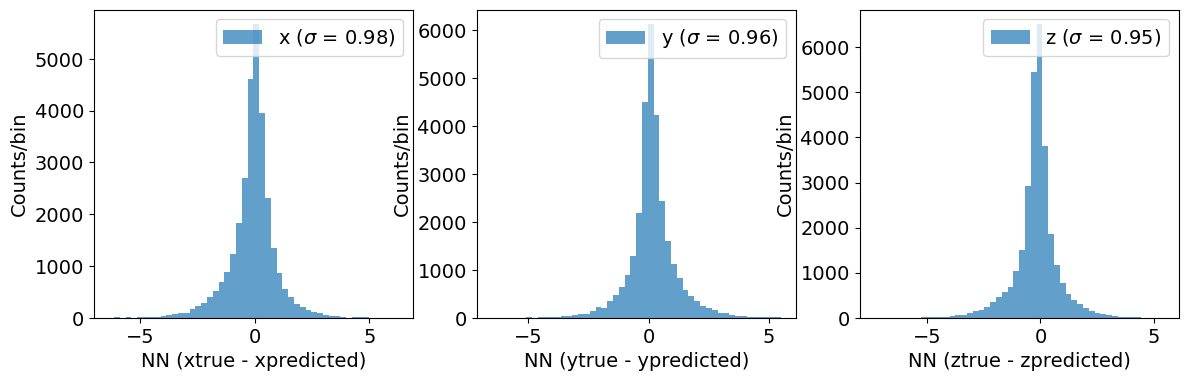

In [38]:
plotxyz()